Tutorial:
- https://github.com/huggingface/notebooks/blob/e1983033bf88432e1e371996e1deec2f6ef1c52a/examples/text_classification.ipynb
- https://huggingface.co/blog/ray-tune
- https://huggingface.co/docs/transformers/training

If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [1]:
!python --version

Python 3.10.12


In [3]:
# You need:

# python==3.10.12
# ! pip uninstall -y transformers accelerate
! pip install -q datasets==2.14.3 transformers==4.28.1 accelerate==0.15.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.7 MB/s eta 0:00:00


In [1]:
'''
Authors: Daniel M. Low
License: See license in github repository
'''

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


on_colab = True

if on_colab:
  from google.colab import drive
  project_name = 'rallypoint_suicide_detection'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/input/final_datasets/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/'
else:
  input_dir = './data/input/'
  output_dir = './data/output/'

os.makedirs(output_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fine-tuning a model on a text classification task

In [2]:
toy = False
task = "stb"
model_checkpoint = "roberta-base" # "distilbert-base-uncased"

batch_size = 16

## Loading the dataset

In [3]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset



# dataset = load_dataset('csv', data_files={'train': ['my_train_file_1.csv', 'my_train_file_2.csv'],
#                                             'test': 'my_test_file.csv'},  )

train = pd.read_csv(input_dir+'train.csv', index_col=0)
val = pd.read_csv(input_dir+'val.csv', index_col=0)
test = pd.read_csv(input_dir+'test.csv', index_col=0)
print(train.shape, test.shape)

if toy:
  train = pd.read_csv(input_dir+'train.csv', index_col=0).sample(frac = 0.1)
  val = pd.read_csv(input_dir+'val.csv', index_col=0).sample(frac = 0.1)
  test = pd.read_csv(input_dir+'test.csv', index_col=0).sample(frac = 0.1)



# # We'll use CV for hyperparameter tuning, so we'll concatenate the train and val data
# # train = train.append(val).reset_index(drop=True)
# # train = train.sample(frac=1).reset_index(drop=True)

# # Torch
# # ============
# from datasets import Dataset, DatasetDict

# train_ds = Dataset.from_pandas(train[['content', 'label']], split="train")
# val_ds = Dataset.from_pandas(val[['content', 'label']], split="validation")
# test_ds = Dataset.from_pandas(test[['content', 'label']], split="test")

# dataset = DatasetDict()
# dataset['train'] = train_ds
# dataset['validation'] = val_ds
# dataset['test'] = test_ds

# from torch.nn.functional import one_hot
# from torch import Tensor
# import torch
# Numpy
# ===========
X_train = train['content'].values
# X_train_metadata = train[['type_tag_content','contact_size','reputation','type']]
y_train = train['label'].astype(int).values
# y_train = Tensor(y_train).to(torch.int64)
# y_train = one_hot(y_train, num_classes=2)

X_val = val['content'].values
# X_val_metadata = val[['type_tag_content','contact_size','reputation','type']]
y_val = val['label'].astype(int).values
# y_val = Tensor(y_val).to(torch.int64)
# y_val = one_hot(y_val, num_classes=2)

X_test = test['content'].values
# X_test_metadata = test[['type_tag_content','contact_size','reputation','type']]
y_test = test['label'].astype(int).values
# y_test = Tensor(y_test).to(torch.int64)
# y_test = one_hot(y_test, num_classes=2)

d = {'train':Dataset.from_dict({'label':y_train,'text':X_train}),
     'validation':Dataset.from_dict({'label':y_val,'text':X_val}),
     'test':Dataset.from_dict({'label':y_test,'text':X_test})
     }

dataset = DatasetDict(d)


(6478, 10) (1279, 11)


In [4]:
dataset['train']['label'][:10]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [5]:
from datasets import load_dataset
dataset2 = load_dataset("glue", 'cola')
dataset2['train']['label'][:10]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [6]:
from datasets import load_dataset, load_metric

Apart from `mnli-mm` being a special code, we can directly pass our task name to those functions. `load_dataset` will cache the dataset to avoid downloading it again the next time you run this cell.

In [7]:


# actual_task = "mnli" if task == "mnli-mm" else task
# # dataset = load_dataset("glue", actual_task)
# metric = load_metric('glue', actual_task)

In [8]:
from datasets import list_metrics
metrics_list = list_metrics()
print(len(metrics_list))
print(metrics_list)
metric = load_metric("f1")
metric

<ipython-input-8-9d45871bc0e8>:2: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics_list = list_metrics()


122
['accuracy', 'bertscore', 'bleu', 'bleurt', 'brier_score', 'cer', 'character', 'charcut_mt', 'chrf', 'code_eval', 'comet', 'competition_math', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'mape', 'mase', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'nist_mt', 'pearsonr', 'perplexity', 'poseval', 'precision', 'r_squared', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'smape', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics', 'BucketHeadP65/confusion_matrix', 'BucketHeadP65/roc_curve', 'Drunper/metrica_tesi', 'Felipehonorato/eer', 'He-Xingwei/sari_metric', 'JP-SystemsX/nDCG', 'Josh98/nl2bash_m', 'Kyle1668/squad', 'Muennighoff/code_eval_octopack', 'NCSOFT/harim_plus', 'Natooz/ece', 'NikitaMartynov/spell-check-metric', 'Pipatpong/perplexity', 'Splend1dchan/cosine_s

<ipython-input-8-9d45871bc0e8>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


Metric(name: "f1", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    labels (`list` of `int`): The set of labels to include when `average` is not set to `'binary'`, and the order of the labels if `average` is `None`. Labels present in the data can be excluded, for example to calculate a multiclass average ignoring a majority negative class. Labels not present in the data will result in 0 components in a macro average. For multilabel targets, labels are column indices. By default, all labels in `predictions` and `references` are used in sorted order. Defaults to None.
    pos_label (`int`): The class to be considered the positive class, in the case where `average` is set to `binary`. Defaults to 1.
    average (`string`): This parameter is required for multiclass/multilabel targets. If set to `None`, the sco

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set (with more keys for the mismatched validation and test set in the special case of `mnli`).

In [9]:
dataset['train'][0]

{'label': 0,
 'text': "That's kinda where I thought it would be, had not seen those posts"}

To access an actual element, you need to select a split first, then give an index:

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [10]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [11]:
show_random_elements(dataset["train"], num_examples=3)

,label,text
0,0,I would never work for the va. I would volunteer
1,0,"Absolutely! I am unsure how everyone will take my opinion, but we as veterans need to change the current perception of a ""veteran"" first. Many joke about being ""Dysfunctional Veterans"" and not playing nice with others. Let's be honest, if that is what our civilian counterparts hear from us, plus all the media attention on PTS, TBI, instability, suicides, etc, they will not trust us to do our part to help rebuild the economy. We are ticking time bombs to many. Veterans need to step up and be leaders in their community, be humble in the workplace/work their way up the chain if need be, and share their knowledge/intangible skills with their civilian counterparts. Many civilian employers do not provide leadership training on par with what we have been through. Find a mentor, become a mentor.\n\nIt's been brought to my attention that I may think I am more elite than civilians. My best friend called me on it. Now it is ok to think that (we are the 1%), but we have to show it tactfully and humbly. We are joining their world and it's different than what we left when we joined X years ago. Currently, I am transitioning from active duty to head to nursing school so I can do my part and live MY American Dream that will allow me to help people in my community and outside my community when I volunteer to be a traveling nurse.\n\nVeterans see an issue and figure out how to solve it whether or not it is their job, but just because it needs done. This will be game changing for the economy."
2,0,"There is no shame in asking for help. I noticed a soldier was not acting the same after deployment. He deployed with another detachment. I told the SFC I was concerned, we were able to get him the help he needed. \nWhat'sent the poster at the TMC say ""it takes courage and strength to ask for help. "" if one cares they will make sure they get the help they need."


You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [12]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'f1': 0.20338983050847456}

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [14]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [0, 31414, 6, 42, 65, 3645, 328, 2, 2, 2409, 42, 3645, 1411, 19, 24, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [15]:
task = 'stb'

task_to_keys = {
    'stb': ("text", None),
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

We can double check it does work on our current dataset:

In [16]:
sentence1_key, sentence2_key = task_to_keys[task]



if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: That's kinda where I thought it would be, had not seen those posts


We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.

In [17]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [18]:
task

'stb'

In [19]:
sentence1_key, sentence2_key = task_to_keys[task]

preprocess_function(dataset['train'][:5])

{'input_ids': [[0, 1711, 18, 24282, 147, 38, 802, 24, 74, 28, 6, 56, 45, 450, 167, 4570, 2], [0, 100, 524, 5, 704, 9, 127, 12, 826, 13, 522, 6359, 35, 3296, 42743, 73, 29774, 10887, 73, 510, 2685, 495, 131, 15, 622, 4, 1437, 404, 522, 6359, 6, 522, 43290, 4189, 6, 8, 522, 2732, 32, 3279, 352, 2814, 7, 1962, 127, 333, 4, 2], [0, 100, 10745, 358, 363, 13, 1840, 7, 253, 127, 3606, 6, 53, 2085, 38, 33, 7, 253, 24, 2185, 4, 2], [0, 12350, 2949, 4, 370, 73, 1694, 32, 5, 1980, 54, 32, 430, 4, 36698, 32, 667, 7, 1346, 12, 463, 40455, 3842, 12846, 1599, 75, 492, 62, 15, 106, 6, 8, 51, 351, 75, 492, 62, 15, 47, 4, 2315, 103, 244, 12, 11970, 40455, 7, 244, 47, 4, 178, 608, 24, 1937, 129, 817, 24, 4851, 4, 2], [0, 1711, 18, 99, 38, 21, 2053, 4, 38, 399, 75, 190, 146, 24, 149, 5, 1786, 9, 5, 527, 4, 370, 393, 28930, 22, 2362, 113, 11, 10, 7337, 1155, 142, 24, 4428, 95, 101, 22, 2977, 845, 39895, 18, 32, 6523, 7, 5, 1933, 98, 4, 1993, 39895, 18, 218, 75, 283, 31, 5217, 2833, 6, 51, 283, 31, 5, 9755,

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [20]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6478 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Map:   0%|          | 0/1279 [00:00<?, ? examples/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels):

In [21]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2
print("num unique values for the label (1 = regression, 2= binary 3 or more=multiclass):", num_labels)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

num unique values for the label (1 = regression, 2= binary 3 or more=multiclass): 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [22]:

metric_name = "f1" if task == "stb" else "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
metric_name

'f1'

In [34]:


model_name = model_checkpoint.split("/")[-1]

if toy:
  epochs = 2
else:
  epochs = 3

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,

  push_to_hub=False,

)

In [35]:

model_name

'roberta-base'

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

In [36]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [37]:

encoded_dataset["train"]

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 6478
})

In [38]:
# task = 'mrpc'
# sentence1_key, sentence2_key = task_to_keys[task]



# encoded_dataset2 = dataset2.map(preprocess_function, batched=True)

# # task = 'stb'
# # sentence1_key, sentence2_key = task_to_keys[task]

In [39]:

encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 6478
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 692
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1279
    })
})

In [40]:
validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"
print(validation_key)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
  compute_metrics=compute_metrics,
    # per_device_train_batch_size=batch_size,
    # per_device_eval_batch_size =

)

validation


In [41]:
# import torch
# x = torch.randn(20, 5)
# y = torch.randint(0, 5, (20,)) # classes
# from collections import Counter
# y


In [42]:

from torch import nn
from transformers import Trainer

from sklearn.utils.class_weight import compute_class_weight

class_weights =  compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
print(class_weights)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

[0.55452833 5.08477237]


You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

In [32]:
import torch # needed

In [43]:
epochs

3

In [44]:
%%time
# distilroberta 18m (4 epochs)

trainer = CustomTrainer(
        model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
  compute_metrics=compute_metrics,

)
trainer.train()



import datetime

ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir_i = output_dir+model_checkpoint+f'_{ts}/'
os.makedirs(output_dir_i , exist_ok=True)
trainer.save_model(output_dir_i)

# to load: model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.289975,0.752475
2,0.474800,0.232681,0.796610
3,0.231300,0.260361,0.852174


CPU times: user 26min 38s, sys: 22 s, total: 27min
Wall time: 27min 31s


In [45]:
from sklearn import metrics
y_pred_proba = trainer.predict(test_dataset=encoded_dataset["test"]).predictions

y_pred_proba = np.array(y_pred_proba)
y_pred_proba_1 = y_pred_proba[:,1]
y_pred = [np.argmax(n) for n in y_pred_proba]

test['y_pred_proba_0'] = y_pred_proba[:,0]
test['y_pred_proba_1'] = y_pred_proba[:,1]
test['y_pred'] = y_pred
output_dir_results = output_dir_i+'results/'
os.makedirs(output_dir_results, exist_ok=True)
test.to_csv(output_dir_results+'test_predictions.csv', index=False)

# y_pred = [int(np.argmax(n)) for n in y_pred_proba]
print(metrics.classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1169
           1       0.59      0.76      0.66       110

    accuracy                           0.93      1279
   macro avg       0.78      0.86      0.81      1279
weighted avg       0.94      0.93      0.94      1279



In [46]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, recall_score, precision_score, f1_score, auc, precision_recall_curve

def metrics_report_cm(y_true, y_pred, output_dir, model_name, ts, save=True):

    cm = confusion_matrix(y_true, y_pred,normalize=None)
    cm_df = pd.DataFrame(cm, index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])
    cm_df_meaning = pd.DataFrame([['TN', 'FP'],['FN','TP']], index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])

    cm_norm = confusion_matrix(y_true, y_pred,normalize='all')
    cm_norm = (cm_norm*100).round(2)
    cm_df_norm = pd.DataFrame(cm_norm, index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])


    plt.rcParams['figure.figsize'] = [4,4]
    cm_display = ConfusionMatrixDisplay(cm_norm,display_labels=['SITB-', 'SITB+']).plot()
    # todo save

    if save:
        cm_df_meaning.to_csv(output_dir+f'cm_meaning_{model_name}_{ts}.csv')
        cm_df.to_csv(output_dir+f'cm_{model_name}_{ts}.csv')
        cm_df_norm.to_csv(output_dir+f'cm_norm_{model_name}_{ts}.csv')



    return cm_df_meaning, cm_df, cm_df_norm




def metrics_report_classification_report(y_true, y_pred,y_pred_proba_1, output_dir, model_name, ts):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    np.set_printoptions(suppress=True)
    roc_auc = roc_auc_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)

    # calculate precision and recall for each threshold
    lr_precision, lr_recall, thresholds = precision_recall_curve(y_true, y_pred_proba_1)

    # TODO: add best threshold
    fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)
    fscore[np.isnan(fscore)] = 0
    ix = np.argmax(fscore)
    best_threshold = thresholds[ix].item()


    pr_auc = auc(lr_recall, lr_precision)
    # AU P-R curve is also approximated by avg. precision
    # avg_pr = metrics.average_precision_score(y_true,y_pred_proba_1)

    sensitivity = recall_score(y_true,y_pred)
    specificity = tn / (tn+fp) # OR: recall_score(y_true,y_pred, pos_label=0)
    precision = precision_score(y_true,y_pred)

    results = pd.DataFrame([sensitivity, specificity,precision,f1, roc_auc,pr_auc, best_threshold],
                        index = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'ROC AUC','PR AUC', 'Best th PR AUC']).T.round(2)

    results.to_csv(output_dir+f'results_{model_name}_{ts}.csv')
    return results




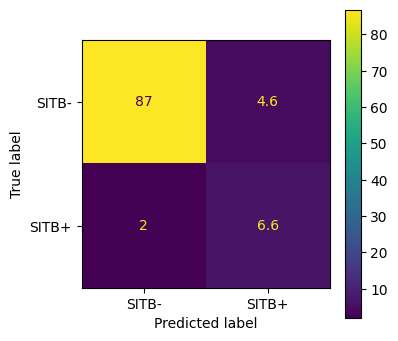

In [47]:

from sklearn import metrics




results = {}

clf_report_sklearn = metrics.classification_report(y_test,y_pred, output_dict=False) #evaluate #different than the output of cross_validate() above.
cm_df_meaning, cm_df, cm_df_norm = metrics_report_cm(y_test, y_pred, output_dir_results, model_name, ts, save=True)
clf_report = metrics_report_classification_report(y_test,y_pred,y_pred_proba_1, output_dir_results, model_name, ts)
# scores = cross_validate(pipe, X, y, scoring=['f1','precision', 'recall'], cv=cv, return_train_score=False) #train and evaluate
results[model_name] = {
    'clf_report': clf_report,
    'cm_df_meaning': cm_df_meaning,
    'cm_df': cm_df,
    'cm_df_norm': cm_df_norm,
    'clf_report_sklearn': clf_report_sklearn

}



In [48]:
for k, v in results.get(model_name).items():
    print(k)
    if k != 'clf_report_sklearn':
      display(v)
    else:
      print(v)
    print()

clf_report


,Sensitivity,Specificity,Precision,F1,ROC AUC,PR AUC,Best th PR AUC
0,0.76,0.95,0.59,0.66,0.86,0.73,1.05



cm_df_meaning


,SITB-,SITB+
SITB-,TN,FP
SITB+,FN,TP



cm_df


,SITB-,SITB+
SITB-,1110,59
SITB+,26,84



cm_df_norm


,SITB-,SITB+
SITB-,86.79,4.61
SITB+,2.03,6.57



clf_report_sklearn
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1169
           1       0.59      0.76      0.66       110

    accuracy                           0.93      1279
   macro avg       0.78      0.86      0.81      1279
weighted avg       0.94      0.93      0.94      1279




In [40]:
# trainer.evaluate(eval_dataset=encoded_dataset["test"])

{'eval_loss': 0.8276265263557434,
 'eval_f1': 0.5798319327731092,
 'eval_runtime': 19.4177,
 'eval_samples_per_second': 65.868,
 'eval_steps_per_second': 4.12,
 'epoch': 4.0}

In [41]:
# trainer.evaluate()

{'eval_loss': 0.5110301375389099,
 'eval_f1': 0.6956521739130433,
 'eval_runtime': 10.5455,
 'eval_samples_per_second': 65.62,
 'eval_steps_per_second': 4.172,
 'epoch': 4.0}

In [ ]:
# load model:
#  - https://discuss.huggingface.co/t/how-to-save-my-model-to-use-it-later/20568/6
# - model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
# - then just load the trainer, but instead of training you just predict (here I'm training to fine tune, but if we load the fine tuned model , there's no need)




We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

To see how your model fared you can compare it to the [GLUE Benchmark leaderboard](https://gluebenchmark.com/leaderboard).

You can now upload the result of the training to the Hub, just execute this instruction:

In [73]:
# encoding = tokenizer(X_test, return_tensors="pt")

# encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
# encoding = {k: v.to(trainer.model.device) for k,v in encoded_dataset["test"]}

# outputs = trainer.model(**encoded_dataset["test"])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (activation): GELUActivation()
          )
          (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        )
      )
    )
  )
  (pre_classifier): Linear(in_features=768, out_features=768, bias=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) argument after ** must be a mapping, not Dataset

In [69]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(output_dir)
model.evaluate()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1614 in __getattr__           │
│                                                                                                  │
│   1611 │   │   │   modules = self.__dict__['_modules']                                           │
│   1612 │   │   │   if name in modules:                                                           │
│   1613 │   │   │   │   return modules[name]                                                      │
│ ❱ 1614 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1615 │   │   │   type(self).__name__, name))                                                   │
│   1616 │                                                                                         │
│   1617 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'DistilBertForSequenceClassification' object has no attribute 'evaluate'

In [68]:
# model_loaded = model.from_pretrained(output_dir_i)

# # model_loaded = model.from_pretrained(output_dir)
# y_pred_proba = model.predict_proba(encoded_dataset["test"])
# y_pred_proba = np.array(y_pred_proba)
# y_pred_proba_1 = y_pred_proba[:,1]
# y_pred = [np.argmax(n) for n in y_pred_proba]

y_pred = model.predict(encoded_dataset["test"])

from sklearn import metrics
# y_pred = [int(np.argmax(n)) for n in y_pred_proba]
print(metrics.classification_report(y_pred=y_pred, y_true=y_test))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 9>:9                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1614 in __getattr__           │
│                                                                                                  │
│   1611 │   │   │   modules = self.__dict__['_modules']                                           │
│   1612 │   │   │   if name in modules:                                                           │
│   1613 │   │   │   │   return modules[name]                                                      │
│ ❱ 1614 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1615 │   │   │   type(self).__name__, name))                                                   │
│   1616 │                                                                                         │
│   1617 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'DistilBertForSequenceClassification' object has no attribute 'predict'

In [28]:
# trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("sgugger/my-awesome-model")
```

## Hyperparameter search

The `Trainer` supports hyperparameter search using [optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/). For this last section you will need either of those libraries installed, just uncomment the line you want on the next cell and run it.

In [36]:
# I install both and it worked
! pip install ray[tune]==2.6.2
! pip install optuna==3.2.0


During hyperparameter search, the `Trainer` will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:

In [37]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

And we can instantiate our `Trainer` like before:

In [38]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

The method we call this time is `hyperparameter_search`. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the `train_dataset` line above by:
```python
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10)
```
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [40]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2023-08-06 19:46:09,703] A new study created in memory with name: no-name-255f7c31-4a37-48f6-be62-88218b9a3255
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpo

Epoch,Training Loss,Validation Loss


[W 2023-08-06 19:46:11,345] Trial 0 failed with parameters: {'learning_rate': 6.128043935291112e-05, 'num_train_epochs': 3, 'seed': 28, 'per_device_train_batch_size': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/usr/local/lib/python3.10/dist-packages/transformers/integrations.py", line 198, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1662, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1929, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2692, in training_step
    inputs = self._prepare_inputs(inputs)
  File 


KeyboardInterrupt



The `hyperparameter_search` method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [41]:
best_run

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'best_run' is not defined

You can customize the objective to maximize by passing along a `compute_objective` function to the `hyperparameter_search` method, and you can customize the search space by passing a `hp_space` argument to `hyperparameter_search`. See this [forum post](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10) for some examples.

To reproduce the best training, just set the hyperparameters in your `TrainingArgument` before creating a `Trainer`:

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467531,0.446775
2,0.428433,0.476509,0.521516


TrainOutput(global_step=536, training_loss=0.4191349371155696)